## Classifying Audio Vs Visual labels 

In [45]:
%run ../preprocessing/Artifact_Removal/preprocecssing_helpers.ipynb
%run ../preprocessing/StimCodes.ipynb
%run ../Classification/ConcatEpochTrails.ipynb
%run ../PCA/Emmanuil-PCA.ipynb
import mne 

from mne.decoding import Vectorizer
from sklearn.preprocessing import MinMaxScaler, Normalizer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.svm import SVC  # noqa
from sklearn.model_selection import ShuffleSplit  # noqa

from mne.decoding import UnsupervisedSpatialFilter
from sklearn.decomposition import PCA

from sklearn.metrics import confusion_matrix
from mne.viz import tight_layout

import time

In [21]:
path = 'E:\EpochedEEG'
epoch_files = os.listdir(path)
file = os.path.join(path, epoch_files[2])

In [85]:
# read epoch object 
epoch = mne.read_epochs(file, preload= True)

Reading E:\EpochedEEG\20131216_1441_epo.fif ...
    Found the data of interest:
        t =    -199.22 ...     500.00 ms
        0 CTF compensation matrices available
5424 matching events found
Applying baseline correction (mode: mean)
5424 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated


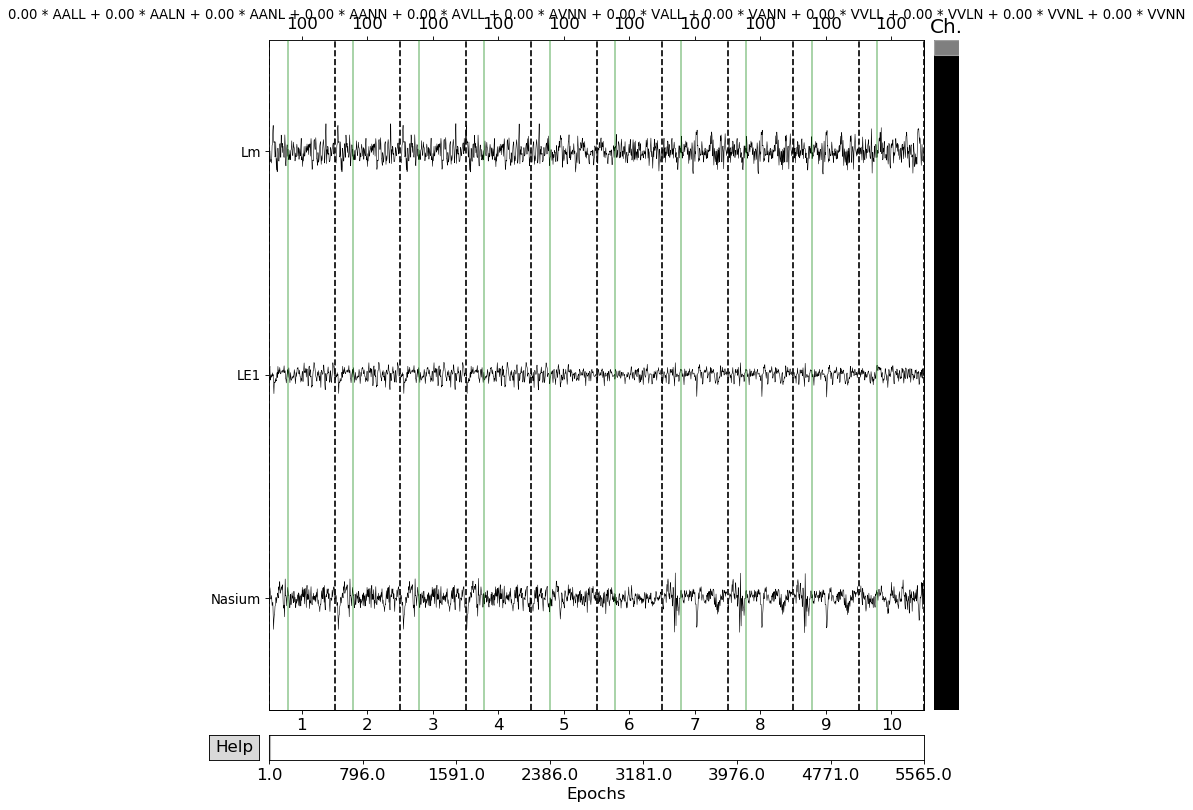

In [74]:
epoch.plot(n_channels=3, n_epochs=10);

In [23]:
# get indicies of trials of epoch object
trial_index_list = get_trial_index_list(epoch_object= epoch)

In [24]:
# get new events for epoch object
new_event_list = convert_event_ids_to_stim_combinations(epoch_object=epoch,
                                                        trial_index_list = trial_index_list,
                                                        stim_combinations = stim_combinations)

events shape: (5565, 3)

Could not find stim-code combination.
error in trial index: (0, 0)
(661, 1)


In [25]:
print(epoch.events.shape)
print(new_event_list.shape)

(5565, 3)
(5565, 3)


In [26]:
# assign new events to current epoch object
epoch.events = new_event_list

# assign new event_ids to current epoch object (dictionary 
# found in ../Classification/ConcatEpochTrails.ipynb)
 
epoch.event_id = modality_lexicality_event_ids

In [27]:
# classification time!

# Isolate audio vs visual codes
# audio codes are < 700, # visual codes are > 700 
# audio : 100 , visual : 101
for event in epoch.events:
    if event[-1] < 700:
        event[-1] = 100
    else:
        event[-1] = 101

In [28]:
norm_pipe = make_pipeline(Vectorizer(), 
                          StandardScaler())
norm_pipe.fit(epoch.get_data())

Pipeline(memory=None,
     steps=[('vectorizer', <mne.decoding.transformer.Vectorizer object at 0x000001688014A048>), ('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True))])

In [29]:
scaled_data = norm_pipe.transform(epoch.get_data())
scaled_data.shape

(5565, 23220)

In [30]:
scaled_data[:,1].shape
epoch.get_data()[:,:20,].shape

(5565, 20, 180)

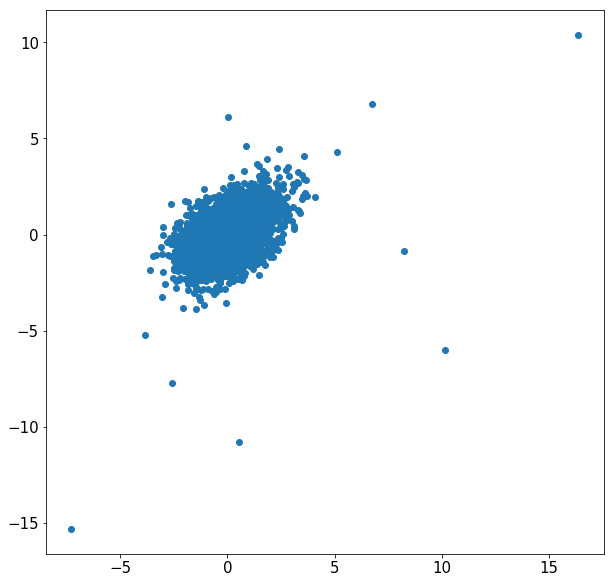

In [31]:
plt.scatter(scaled_data[:,1],scaled_data[:,2]);

In [32]:
# do PCA to reduce dimensions and data needed for classification.
pca = UnsupervisedSpatialFilter(PCA(28), average=False) # PCA, keep 9 components 

epoch_data = epoch.get_data()
pca_data = pca.fit_transform(epoch_data)

In [33]:
pca_data.shape

(5565, 28, 180)

In [62]:
# classification pipeline
start = time.time()
clf = make_pipeline(Vectorizer(),
                    StandardScaler(),
                    LogisticRegression(penalty='l1'))
end = time.time()
print("clf elapsed time: {0}".format(end - start))

start_master = time.time()
cv = StratifiedKFold(n_splits=5, shuffle = True, random_state = 42)

labels = epoch.events[:,-1]
preds = np.empty(len(pca_data))
for train, test in cv.split(pca_data, labels):
    start = time.time()
    clf.fit(pca_data[train], labels[train])
    preds[test] = clf.predict(pca_data[test])
    end = time.time()
    print("kfold elapsed time: {0}".format(end - start))
end = time.time()
print("classification elapsed time: {0}".format(end - start_master))


start = time.time()
target_names = ['Audio', 'Visual']
report = classification_report(labels, preds, target_names=target_names)
print(report)
end = time.time()
print("reporting elapsed time: {0}".format(end - start))

clf elapsed time: 0.0010151863098144531
kfold elapsed time: 20.355138301849365
kfold elapsed time: 22.34942889213562
kfold elapsed time: 19.645958185195923
kfold elapsed time: 19.15437150001526
kfold elapsed time: 18.15023922920227
classification elapsed time: 99.66859364509583
             precision    recall  f1-score   support

      Audio       0.61      0.60      0.60      3041
     Visual       0.53      0.54      0.53      2524

avg / total       0.57      0.57      0.57      5565

reporting elapsed time: 0.0049896240234375


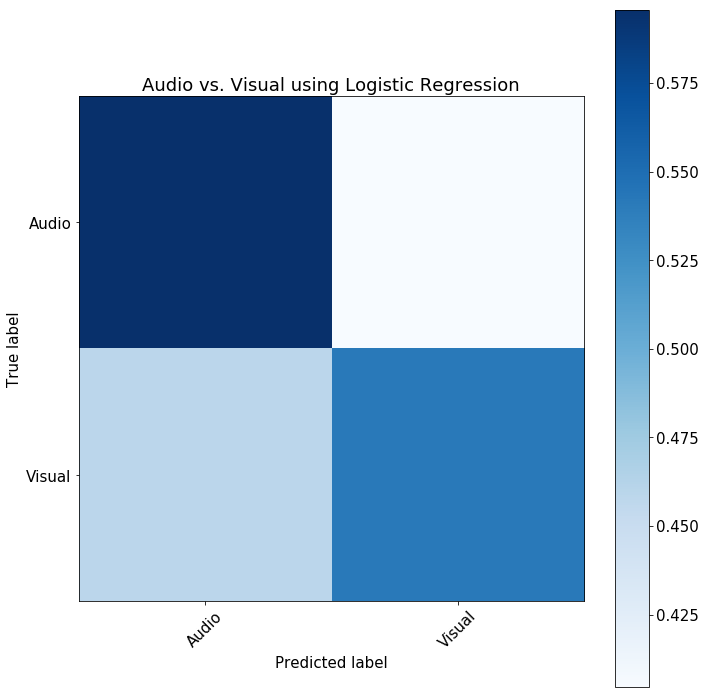

In [65]:
cm3 = confusion_matrix(labels, preds)
cm3_normalized = cm3.astype(float) / cm3.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix
plt.imshow(cm3_normalized, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Audio vs. Visual using Logistic Regression')
plt.colorbar()
tick_marks = np.arange(len(target_names))
plt.xticks(tick_marks, target_names, rotation=45)
plt.yticks(tick_marks, target_names)
tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [37]:
# classification pipeline
start = time.time()
clf = make_pipeline(Vectorizer(),
                    StandardScaler(),
                    LogisticRegression(penalty='l1'))
end = time.time()
print("clf elapsed time: {0}".format(end - start))

start_master = time.time()
cv = StratifiedKFold(n_splits=5, shuffle = True, random_state = 42)

labels = epoch.events[:,-1]
preds = np.empty(len(pca_data))
for train, test in cv.split(pca_data, labels):
    start = time.time()
    clf.fit(pca_data[train], labels[train])
    preds[test] = clf.predict(pca_data[test])
    end = time.time()
    print("kfold elapsed time: {0}".format(end - start))
end = time.time()
print("classification elapsed time: {0}".format(end - start_master))


start = time.time()
target_names = ['Audio', 'Visual']
report = classification_report(labels, preds, target_names=target_names)
print(report)
end = time.time()
print("reporting elapsed time: {0}".format(end - start))

clf elapsed time: 0.0004982948303222656
kfold elapsed time: 19.724311351776123
kfold elapsed time: 20.414028882980347
kfold elapsed time: 17.88772749900818
kfold elapsed time: 19.18182134628296
kfold elapsed time: 18.725172519683838
classification elapsed time: 95.95502233505249
             precision    recall  f1-score   support

      Audio       0.61      0.60      0.60      3041
     Visual       0.53      0.54      0.53      2524

avg / total       0.57      0.57      0.57      5565

reporting elapsed time: 0.004492044448852539


In [ ]:
#reduce dimensions by converting the 180 ms of points in time into 3 values which are variance, skewness, and kurtosis 

In [50]:
mean_statisitcs = get_mean_band(pca_data)

In [51]:
mean_statisitcs = mean_statisitcs.swapaxes(1,2)

In [54]:
# classification pipeline
start = time.time()
clf = make_pipeline(Vectorizer(),
                    StandardScaler(),
                    LogisticRegression(penalty='l1'))
end = time.time()
print("clf elapsed time: {0}".format(end - start))

start_master = time.time()
cv = StratifiedKFold(n_splits=5, shuffle = True, random_state = 42)

labels = epoch.events[:,-1]
preds = np.empty(len(mean_statisitcs))
for train, test in cv.split(mean_statisitcs, labels):
    start = time.time()
    clf.fit(mean_statisitcs[train], labels[train])
    preds[test] = clf.predict(mean_statisitcs[test])
    end = time.time()
    print("kfold elapsed time: {0}".format(end - start))
end = time.time()
print("classification elapsed time: {0}".format(end - start_master))


start = time.time()
target_names = ['Audio', 'Visual']
report = classification_report(labels, preds, target_names=target_names)
print(report)
end = time.time()
print("reporting elapsed time: {0}".format(end - start))

clf elapsed time: 0.0010006427764892578
kfold elapsed time: 2.846230983734131
kfold elapsed time: 2.6286113262176514
kfold elapsed time: 3.3472743034362793
kfold elapsed time: 2.5971827507019043
kfold elapsed time: 2.5522546768188477
classification elapsed time: 13.98850393295288
             precision    recall  f1-score   support

      Audio       0.70      0.73      0.71      3041
     Visual       0.66      0.61      0.63      2524

avg / total       0.68      0.68      0.68      5565

reporting elapsed time: 0.005489349365234375


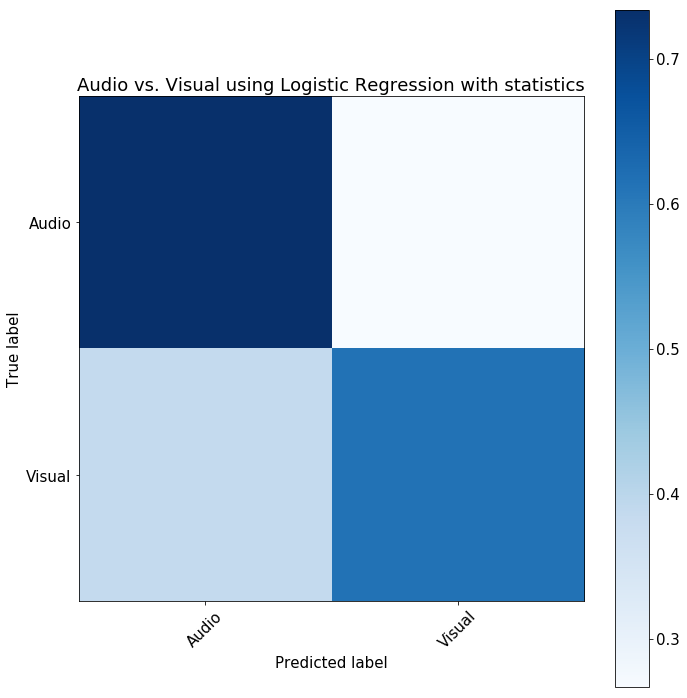

In [56]:
cm3 = confusion_matrix(labels, preds)
cm3_normalized = cm3.astype(float) / cm3.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix
plt.imshow(cm3_normalized, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Audio vs. Visual using Logistic Regression with statistics')
plt.colorbar()
tick_marks = np.arange(len(target_names))
plt.xticks(tick_marks, target_names, rotation=45)
plt.yticks(tick_marks, target_names)
tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [57]:
# try this again without PCA data

In [58]:
epoch_mean_statistics = get_mean_band(epoch.get_data())
epoch_mean_statistics = epoch_mean_statistics.swapaxes(1,2)

In [66]:
# classification pipeline
start = time.time()
clf = make_pipeline(Vectorizer(),
                    StandardScaler(),
                    LogisticRegression(penalty='l1'))
end = time.time()
print("clf elapsed time: {0}".format(end - start))

start_master = time.time()
cv = StratifiedKFold(n_splits=5, shuffle = True, random_state = 42)

labels = epoch.events[:,-1]
preds = np.empty(len(epoch_mean_statistics))
for train, test in cv.split(epoch_mean_statistics, labels):
    start = time.time()
    clf.fit(epoch_mean_statistics[train], labels[train])
    preds[test] = clf.predict(epoch_mean_statistics[test])
    end = time.time()
    print("kfold elapsed time: {0}".format(end - start))
end = time.time()
print("classification elapsed time: {0}".format(end - start_master))


start = time.time()
target_names = ['Audio', 'Visual']
report = classification_report(labels, preds, target_names=target_names)
print(report)
end = time.time()
print("reporting elapsed time: {0}".format(end - start))

clf elapsed time: 0.000997781753540039
kfold elapsed time: 25.724650144577026
kfold elapsed time: 12.335554599761963
kfold elapsed time: 13.21841311454773
kfold elapsed time: 13.021776676177979
kfold elapsed time: 15.831552982330322
classification elapsed time: 80.14492797851562
             precision    recall  f1-score   support

      Audio       0.79      0.80      0.79      3041
     Visual       0.75      0.74      0.75      2524

avg / total       0.77      0.77      0.77      5565

reporting elapsed time: 0.00648951530456543


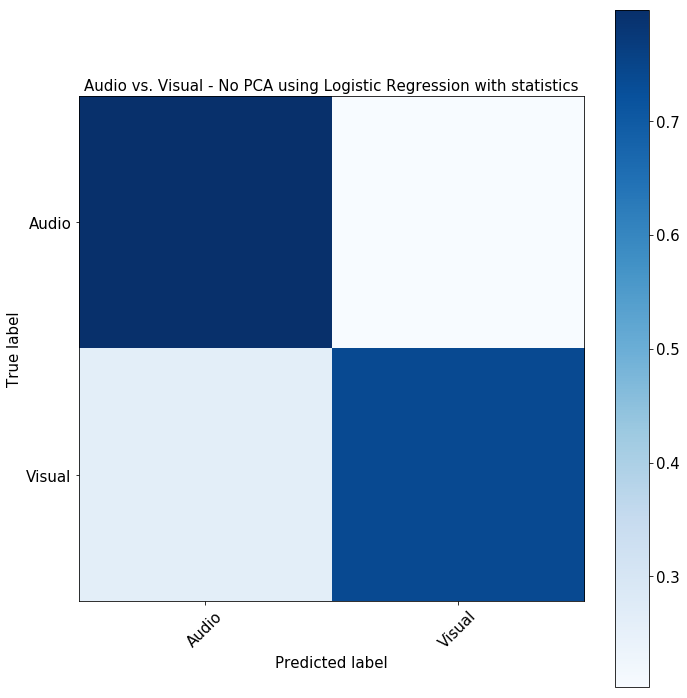

In [72]:
cm3 = confusion_matrix(labels, preds)
cm3_normalized = cm3.astype(float) / cm3.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix
plt.imshow(cm3_normalized, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Audio vs. Visual - No PCA using Logistic Regression with statistics', size = 15)
plt.colorbar()
tick_marks = np.arange(len(target_names))
plt.xticks(tick_marks, target_names, rotation=45)
plt.yticks(tick_marks, target_names)
tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [75]:
epoch_mean_statistics.shape

(5565, 129, 3)

In [76]:
preprocess = make_pipeline(Vectorizer(),
                           StandardScaler())

In [77]:
scaled_epoch_mean_statistics = preprocess.fit_transform(epoch_mean_statistics)

In [79]:
X_train, X_test, y_train, y_test = train_test_split(scaled_epoch_mean_statistics,labels, test_size = 0.3, random_state = 42)

In [80]:
lgr_clf = LogisticRegression()

In [81]:
lgr_clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [82]:
lgr_clf.score(X_test, y_test)

0.7676646706586826

In [89]:
epoch.events[:,-1][:15]

array([131,  31, 144, 162,   8,   3,   7, 132, 134, 130,  31, 142, 162,
         8,   3])

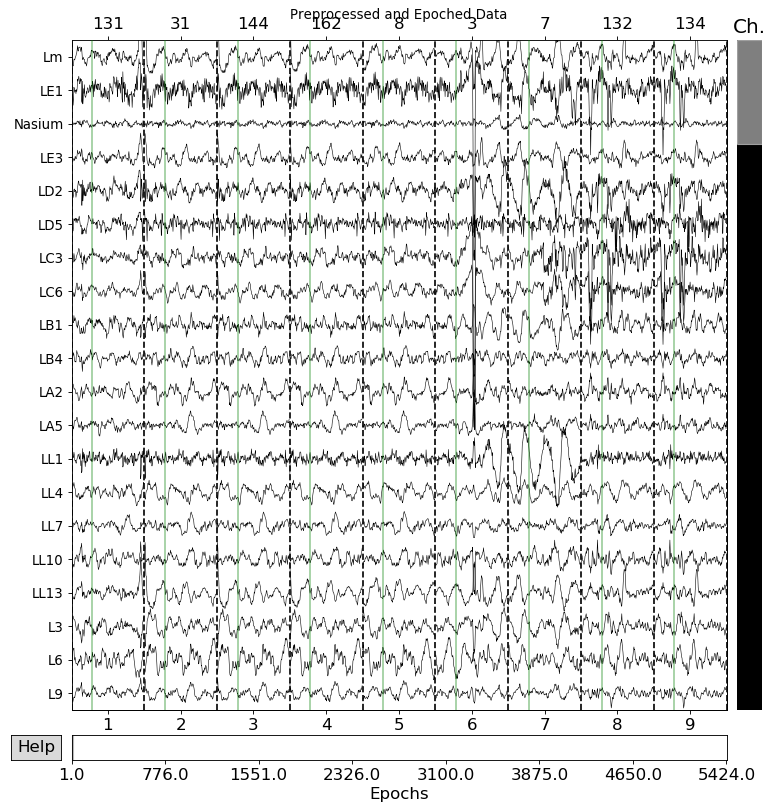

In [90]:
epoch.plot(n_channels= 20, n_epochs = 9, title = "Preprocessed and Epoched Data");